# Homework 2

**Name**: **Arvin Hosseini**

**UID**: **205594617**

Note: Please remember to make a copy of this colab notebook in your drive.

In [ ]:
# Download a processed version of the data
#!wget https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt

In [ ]:
# Use only the provided packages!
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
# load data from txt
# X.shape = (n_examples, n_features), y.shape = (n_examples, )
def load_data(filename):
    data = pandas.read_csv(filename).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1

    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(sorted(set(data[:, i+1])))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]

    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)

    return X, y

In [ ]:
def create_data(filename, test_size=0.15, val_size=0.15):
    # Load the dataset
    X, y = load_data(filename='mushroom.txt')

    # Split into train, validation, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)
    X_train, X_val, X_test = torch.Tensor(X_train), torch.Tensor(X_val), torch.Tensor(X_test)
    y_train = torch.Tensor(np.array([ [y] for y in y_train ]))
    y_val = torch.Tensor(np.array([ [y] for y in y_val ]))
    y_test = torch.Tensor(np.array([ [y] for y in y_test ]))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=16, test_batch_size=32):
    # part a: Create dataloaders for train, validation and test sets

    # create tensor datasets for each type of data
    training_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)


    #create dataloaders for each type of the datasets
    train_loader = DataLoader(training_data, batch_size=16)
    val_loader = DataLoader(val_data, batch_size=32)
    test_loader = DataLoader(test_data, batch_size=32)




    return train_loader, val_loader, test_loader

In [ ]:
def evaluate_loss(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    for batch_X, batch_y in dataloader:
        batch_size = len(batch_X)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

    return total_loss / len(dataloader.dataset)

In [ ]:
def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = (outputs > 0.5).long()
        total_acc += (predictions==batch_y).sum()
        
    return total_acc / len(dataloader.dataset)

In [ ]:


class OneLayerNetwork(torch.nn.Module):
    def __init__(self, input_features):
        # input_features: int
        super(OneLayerNetwork, self).__init__()

      
        ### part c: implement OneLayerNetwork with torch.nn.Linear. Use sigmoid as the activation

        #create w and sigmoid defintions using linear and sigmoid functions from pytorch
        self.w = torch.nn.Linear(input_features, 1)
        self.sig = torch.nn.Sigmoid()

        

    def forward(self, x):
        # x.shape = (n_batch, n_features)

        

        #calculate sigmoid of w 
        temp = self.w(x)
        outputs = self.sig(temp)

        
        return outputs

In [ ]:
def init_oneLayerNN(in_features, lr):
    # input_features: int -> Number of input features
    # lr: float -> Learning Rate

    
    
    #create an instance of the one later network using the input features
    model = OneLayerNetwork(in_features)
    #use loss function from pytorch using sum
    criterion = torch.nn.BCELoss(reduction='sum')
    #use sgd otimizer from pytorch with the inputted learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    

    
    return model, criterion, optimizer

In [ ]:

class TwoLayerNetwork(torch.nn.Module):
    def __init__(self, input_features, hidden_features, first_activation='sigmoid'):
        # input_features: int -> Number of input features
        # hidden_features: int -> Size of the hidden layer
        # first_activation: str -> Activation to use for the first hidden layer
        
        super(TwoLayerNetwork, self).__init__()
       

        #define w1 as the matrix of weights from the input layers to the hidden layer
        self.w1 = torch.nn.Linear(input_features, hidden_features)
        #define w2 as the matrix of weights from the hidden layeer to the predicted output 
        self.w2 = torch.nn.Linear(hidden_features, 1)
        #make sure that we are using the correct activation function
        if first_activation == 'sigmoid':
          self.sig = torch.nn.Sigmoid()
        else:
          print(f"{first_activation} not implemented.")

       
    def forward(self, x):
        # x.shape = (n_batch, n_features)

        #first find sigmoid of w1 given an input x
        temp = self.sig(self.w1(x))
        #then matrix multiply the result with w2 and call the sigmoid function on the result
        outputs = self.sig(self.w2(temp))

        return outputs

In [ ]:
def init_twoLayerNN(in_features, hidden_size, first_activation, lr):
    # input_features: int -> Number of input features
    # hidden_features: int -> Size of the hidden layer
    # first_activation: str -> Activation to use for the first hidden layer
    # lr: float -> Learning Rate

    # create an instance of the two layer NN using the passed in paramters
    model = TwoLayerNetwork(in_features, hidden_size, first_activation)
    criterion = torch.nn.BCELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)


    return model, criterion, optimizer

In [ ]:
def train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, logging_epochs=1):
    print("Start training model...")

    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(1, num_epochs+1):
        model.train()
        for batch_X, batch_y in train_loader:
            

            # initialize to grads to 0
            optimizer.zero_grad()

            # forward pass
            outputs = model(batch_X)
            # calc the loss
            loss = criterion(outputs, batch_y)
            # calculate gradients using backprop
            loss.backward()
            # updating the weights
            optimizer.step()

            
        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        if logging_epochs > 0 and epoch % logging_epochs == 0:
            print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [ ]:
# fix random seed
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Data Preparation
train_batch_size = 16
test_batch_size = 32

## Load data
X_train, y_train, X_val, y_val, X_test, y_test = create_data("mushroom.txt")

## Create data loaders
train_loader, val_loader, test_loader = get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_batch_size=train_batch_size, test_batch_size=test_batch_size)

In [ ]:
## Define hyperparameters
lr = 0.001
num_epochs = 50

## Init models
oneLayerNN, criterion, optimizer = init_oneLayerNN(X_train.shape[1], lr=lr)
results_one = train(oneLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.546384 | train acc 0.732357 | valid loss 0.545550 | valid acc 0.739049 |
| epoch  2 | train loss 0.537560 | train acc 0.755881 | valid loss 0.539040 | valid acc 0.760485 |
| epoch  3 | train loss 0.533699 | train acc 0.761309 | valid loss 0.536818 | valid acc 0.767008 |
| epoch  4 | train loss 0.530968 | train acc 0.759829 | valid loss 0.535419 | valid acc 0.762349 |
| epoch  5 | train loss 0.528757 | train acc 0.757032 | valid loss 0.534337 | valid acc 0.760485 |
| epoch  6 | train loss 0.526884 | train acc 0.757526 | valid loss 0.533437 | valid acc 0.759553 |
| epoch  7 | train loss 0.525260 | train acc 0.757526 | valid loss 0.532658 | valid acc 0.759553 |
| epoch  8 | train loss 0.523823 | train acc 0.757526 | valid loss 0.531960 | valid acc 0.759553 |
| epoch  9 | train loss 0.522533 | train acc 0.759006 | valid loss 0.531317 | valid acc 0.760485 |
| epoch 10 | train loss 0.521359 | train acc 0.759006 | valid loss 0.530715 | valid a

In [ ]:
## Define hyperparameters
lr = 0.001
hidden_size = 6
activation = 'sigmoid'
num_epochs = 50

## Init models
twoLayerNN, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
results_two = train(twoLayerNN, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

Start training model...
| epoch  1 | train loss 0.667682 | train acc 0.562593 | valid loss 0.668011 | valid acc 0.565704 |
| epoch  2 | train loss 0.652090 | train acc 0.623458 | valid loss 0.651769 | valid acc 0.638397 |
| epoch  3 | train loss 0.635221 | train acc 0.650271 | valid loss 0.634644 | valid acc 0.654240 |
| epoch  4 | train loss 0.615841 | train acc 0.699457 | valid loss 0.615277 | valid acc 0.697111 |
| epoch  5 | train loss 0.594264 | train acc 0.724461 | valid loss 0.593729 | valid acc 0.729730 |
| epoch  6 | train loss 0.573040 | train acc 0.728409 | valid loss 0.572476 | valid acc 0.733458 |
| epoch  7 | train loss 0.554806 | train acc 0.759993 | valid loss 0.554384 | valid acc 0.764212 |
| epoch  8 | train loss 0.539843 | train acc 0.759006 | valid loss 0.539684 | valid acc 0.765144 |
| epoch  9 | train loss 0.527671 | train acc 0.763283 | valid loss 0.527856 | valid acc 0.769804 |
| epoch 10 | train loss 0.517604 | train acc 0.763283 | valid loss 0.518233 | valid a

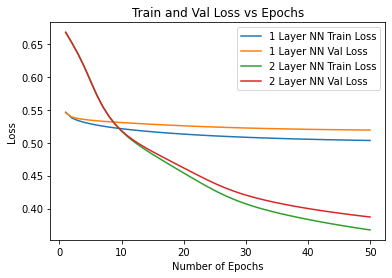

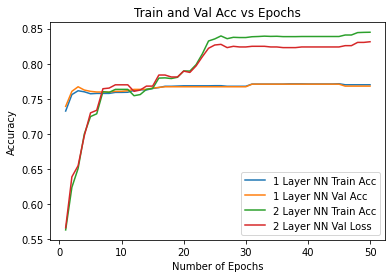

In [ ]:
one_train_loss, one_valid_loss, one_train_acc, one_valid_acc = results_one
two_train_loss, two_valid_loss, two_train_acc, two_valid_acc = results_two


#create list for the number of epochs
epochs = [x for x in range(1, num_epochs + 1)]

#plot the training and validation loss for both NN and add their labels
plot1 = plt.plot(epochs, one_train_loss, label = "1 Layer NN Train Loss")
plot1 = plt.plot(epochs, one_valid_loss, label = "1 Layer NN Val Loss")
plot1 = plt.plot(epochs, two_train_loss, label = "2 Layer NN Train Loss")
plot1 = plt.plot(epochs, two_valid_loss, label = "2 Layer NN Val Loss")
#lable the axis and create the legend
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Train and Val Loss vs Epochs")
plt.legend()

plt.figure()




#plot the training and validatoin loss for training and validation accuracy for both the 1 and 2 layer networks
plot2 = plt.plot(epochs, one_train_acc, label = "1 Layer NN Train Acc")
plot2 = plt.plot(epochs, one_valid_acc, label = "1 Layer NN Val Acc")
plot2 = plt.plot(epochs, two_train_acc, label = "2 Layer NN Train Acc")
plot2 = plt.plot(epochs, two_valid_acc, label = "2 Layer NN Val Loss")
#lable the axis and create the legend
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Val Acc vs Epochs")
plt.legend()


In [ ]:
#Evaluate the test accuracies for both the models. Explain the behavior

#calculate and print the test accuracy for both models using evaluate_acc
test_one_acc = evaluate_acc(oneLayerNN, test_loader)
test_two_acc = evaluate_acc(twoLayerNN, test_loader)

print(f"Test acc for one layer nn is {test_one_acc}")
print(f"Test acc for two layer nn is {test_two_acc}")


Test acc for one layer nn is 0.7783056497573853
Test acc for two layer nn is 0.8353127241134644


In [ ]:
def get_confusion_matrix(model, dataloader):
    

    model.eval()

    #create a list for the y predictions and the true y values
    y_pred = []
    y_true = []
    #iterate over each batch for the given data loader
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        #if the out put is greater than .5 then predict it as a y = 1 value
        pred_curr_batch = (outputs > 0.5).long()
        y_pred += pred_curr_batch.tolist()
        y_true += batch_y.tolist()

    #create the confusion matrix using the true and predicted y vals
    cm = confusion_matrix(y_true, y_pred)

    return cm

In [ ]:
oneLayerNN_cm = get_confusion_matrix(oneLayerNN, val_loader)
twoLayerNN_cm = get_confusion_matrix(twoLayerNN, val_loader)

print ("Confusion Matrix for One Layer NN")
print (oneLayerNN_cm)

print ("Confusion Matrix for Two Layer NN")
print (twoLayerNN_cm)

Confusion Matrix for One Layer NN
[[358 164]
 [ 85 466]]
Confusion Matrix for Two Layer NN
[[387 135]
 [ 46 505]]


Start training model...
| epoch  1 | train loss 0.659122 | train acc 0.634150 | valid loss 0.660634 | valid acc 0.645853 |
| epoch  2 | train loss 0.625759 | train acc 0.643527 | valid loss 0.623605 | valid acc 0.643989 |
| epoch  3 | train loss 0.594285 | train acc 0.708998 | valid loss 0.592174 | valid acc 0.708295 |
| epoch  4 | train loss 0.564014 | train acc 0.744530 | valid loss 0.563553 | valid acc 0.751165 |
| epoch  5 | train loss 0.539472 | train acc 0.770192 | valid loss 0.540712 | valid acc 0.771668 |
| epoch  6 | train loss 0.521528 | train acc 0.771344 | valid loss 0.524155 | valid acc 0.770736 |
| epoch  7 | train loss 0.508347 | train acc 0.759664 | valid loss 0.512117 | valid acc 0.759553 |
| epoch  8 | train loss 0.498011 | train acc 0.758842 | valid loss 0.502775 | valid acc 0.759553 |
| epoch  9 | train loss 0.489279 | train acc 0.768383 | valid loss 0.494943 | valid acc 0.767008 |
| epoch 10 | train loss 0.481470 | train acc 0.769534 | valid loss 0.487968 | valid a

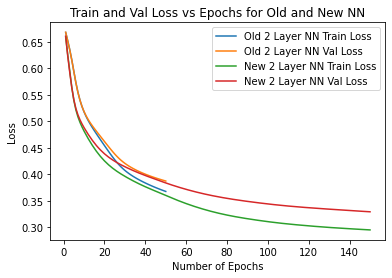

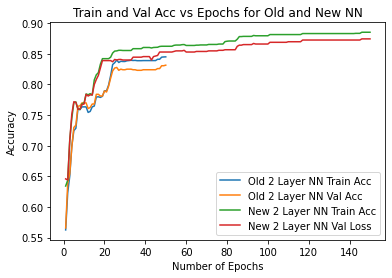

In [ ]:
## Define hyperparameters
lr = 0.001
hidden_size = 20
activation = 'sigmoid'
num_epochs = 150

## Init models
twoLayerNN_new, criterion, optimizer = init_twoLayerNN(X_train.shape[1], hidden_size, activation, lr=lr)
results_two_new = train(twoLayerNN_new, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)


# get data from the new results
two_train_loss_new, two_valid_loss_new, two_train_acc_new, two_valid_acc_new = results_two_new

# plot the resutls for the loss for the old and new NN

epochs_new = [x for x in range(1, num_epochs + 1)]

plt.plot(epochs, two_train_loss, label = "Old 2 Layer NN Train Loss")
plt.plot(epochs, two_valid_loss, label = "Old 2 Layer NN Val Loss")
plt.plot(epochs_new, two_train_loss_new, label = "New 2 Layer NN Train Loss")
plt.plot(epochs_new, two_valid_loss_new, label = "New 2 Layer NN Val Loss")
#lable the axis and create the legend
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Train and Val Loss vs Epochs for Old and New NN")
plt.legend()

plt.figure()

plt.plot(epochs, two_train_acc, label = "Old 2 Layer NN Train Acc")
plt.plot(epochs, two_valid_acc, label = "Old 2 Layer NN Val Acc")
plt.plot(epochs_new, two_train_acc_new, label = "New 2 Layer NN Train Acc")
plt.plot(epochs_new, two_valid_acc_new, label = "New 2 Layer NN Val Loss")
#lable the axis and create the legend
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Val Acc vs Epochs for Old and New NN")
plt.legend()


# find the test accuracy for model based on the new hyper parameters
new_test_two_acc = evaluate_acc(twoLayerNN_new, test_loader)

print(f"Test acc for the new two layer nn is {new_test_two_acc}")
print(f"Test acc for the old two layer nn is {test_two_acc}")
